In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch

from useful_functions_notebook_7 import *
from useful_functions_notebook_8to13 import *
from useful_functions_notebook_14to18 import *

# load model

In [2]:
latent_diffusion_name = "diffusion_notebook/latent_diffusion/mlp/latent_diffusion_model_mlp.pt"
encoder_path = "diffusion_notebook/latent_diffusion/mlp/encoder_model_mlp.pt"


nvar = 3
num_branches = 10
latent_dim = 300
T = 1000


encoder = Encoder(nvar, num_branches, latent_dim)
latent_diffusion_model = LatentDiffusionModel_mlp()

saved_encoder_model = torch.load(encoder_path, map_location = device)
encoder.load_state_dict(saved_encoder_model)

saved_latent_model = torch.load(latent_diffusion_name, map_location = device)
latent_diffusion_model.load_state_dict(saved_latent_model)

<All keys matched successfully>

In [3]:
@torch.no_grad()
def sample_timestep_mlp(model, x, t, betas):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    # Pre-calculate different terms for closed form
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    betas_t = get_index_from_list(betas, t, x.shape)
    
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    noise = torch.randn_like(x)
    return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_image_mlp(model, noise, T, bs):
    img = noise
    betas = linear_beta_schedule(timesteps=T)
    for i in range(0, T)[::-1]:
        t = torch.full((bs,), i, device=device, dtype=torch.long)
        img = sample_timestep_mlp(model, img, t, betas)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)

    return img


# load data

In [4]:
dataset = torch.load("data/dataset_normalized_consistent_only.pt")
one_branch = []
two_branch = []
three_branch = []
four_branch = []
five_branch = []
six_branch = []
seven_branch = []
eight_branch = []
nine_branch = []
ten_branch = []

for datapoint in dataset:
    one_channel = datapoint[1]
    branches = torch.count_nonzero(one_channel, dim=0)
    num_branch = torch.count_nonzero(branches, dim=0)
    if num_branch == 1:
        one_branch.append(datapoint)
    elif num_branch == 2:
        two_branch.append(datapoint)
    elif num_branch == 3:
        three_branch.append(datapoint)
    elif num_branch == 4:
        four_branch.append(datapoint)
    elif num_branch == 5:
        five_branch.append(datapoint)
    elif num_branch == 6:
        six_branch.append(datapoint)
    elif num_branch == 7:
        seven_branch.append(datapoint)
    elif num_branch == 8:
        eight_branch.append(datapoint)
    elif num_branch == 9:
        nine_branch.append(datapoint)
    elif num_branch == 10:
        ten_branch.append(datapoint)
        
total = [one_branch, two_branch, three_branch, four_branch, five_branch,
         six_branch, seven_branch, eight_branch, nine_branch, ten_branch]

total_im = 0
for i, branch_list in enumerate(total):
    total_im += len(branch_list)
    print(f"number of images with {i + 1} branches is: {len(branch_list)}")
    
print(f"double check that all images are counted: total images is {total_im} = {dataset.shape[0]}")

number of images with 1 branches is: 0
number of images with 2 branches is: 0
number of images with 3 branches is: 0
number of images with 4 branches is: 0
number of images with 5 branches is: 7575
number of images with 6 branches is: 8012
number of images with 7 branches is: 7138
number of images with 8 branches is: 5990
number of images with 9 branches is: 4757
number of images with 10 branches is: 3923
double check that all images are counted: total images is 37395 = 37395


# PCA

### input merger tree of size (3, 29, 10)

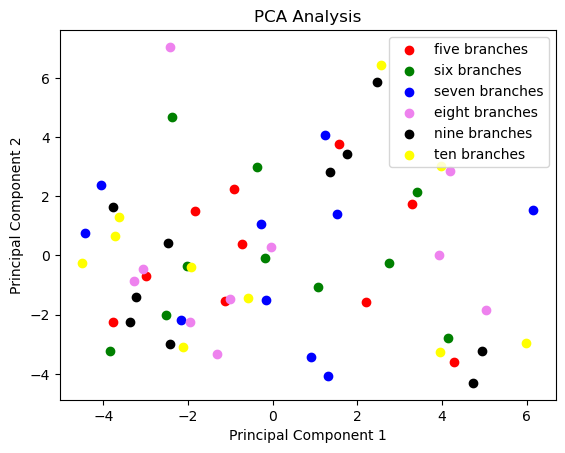

In [5]:
num_samples = 10

five = torch.stack(five_branch)[:num_samples].unsqueeze(0)
six = torch.stack(six_branch)[:num_samples].unsqueeze(0)
seven = torch.stack(seven_branch)[:num_samples].unsqueeze(0)
eight = torch.stack(eight_branch)[:num_samples].unsqueeze(0)
nine = torch.stack(nine_branch)[:num_samples].unsqueeze(0)
ten = torch.stack(ten_branch)[:num_samples].unsqueeze(0)

data = torch.cat([five, six, seven, eight, nine, ten], dim = 0)
data = data.view(data.shape[0], data.shape[1], -1).numpy()

colors = ['red', 'green', 'blue', 'violet', 'black', 'yellow']
branches = ["five", "six", "seven", "eight", "nine", "ten"]


# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization

for i, data_set_branch in enumerate(data):
    data_pca = data_set_branch
    data_reduced = pca.fit_transform(data_pca)
    plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=colors[i], label=f'{branches[i]} branches')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Analysis')
plt.legend()
plt.show()

### latent representation of size 300

torch.Size([6, 10, 300])


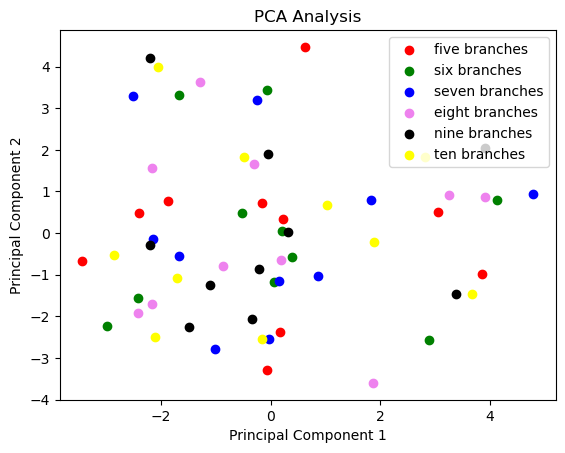

In [18]:
five_latent = encoder(five.squeeze().float())
six_latent = encoder(six.squeeze().float())
seven_latent = encoder(seven.squeeze().float())
eight_latent = encoder(eight.squeeze().float())
nine_latent = encoder(nine.squeeze().float())
ten_latent = encoder(ten.squeeze().float())

five_latent_out = sample_image_mlp(latent_diffusion_model, five_latent, T, num_samples).unsqueeze(0)
six_latent_out = sample_image_mlp(latent_diffusion_model, six_latent, T, num_samples).unsqueeze(0)
seven_latent_out = sample_image_mlp(latent_diffusion_model, seven_latent, T, num_samples).unsqueeze(0)
eight_latent_out = sample_image_mlp(latent_diffusion_model, eight_latent, T, num_samples).unsqueeze(0)
nine_latent_out = sample_image_mlp(latent_diffusion_model, nine_latent, T, num_samples).unsqueeze(0)
ten_latent_out = sample_image_mlp(latent_diffusion_model, ten_latent, T, num_samples).unsqueeze(0)

data = torch.cat([five_latent_out, six_latent_out, seven_latent_out, eight_latent_out, nine_latent_out, ten_latent_out], dim = 0)

print(data.shape)

colors = ['red', 'green', 'blue', 'violet', 'black', 'yellow']
branches = ["five", "six", "seven", "eight", "nine", "ten"]

# Perform PCA analysis
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization

for i, data_set_branch in enumerate(data):
    data_pca = data_set_branch.detach().numpy()
    data_reduced = pca.fit_transform(data_pca)
    plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=colors[i], label=f'{branches[i]} branches')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Analysis')
plt.legend()
plt.show()

# t-SNE

### input merger tree of size (3, 29, 10)

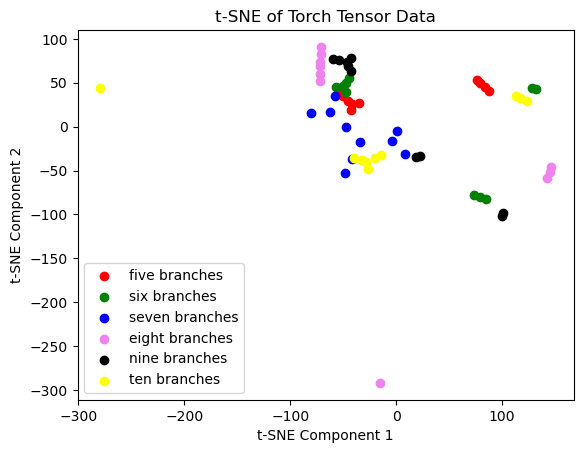

In [22]:
num_samples = 10

data = torch.cat([five, six, seven, eight, nine, ten], dim = 0)
data = data.view(data.shape[0], data.shape[1], -1).numpy()

colors = ['red', 'green', 'blue', 'violet', 'black', 'yellow']
branches = ["five", "six", "seven", "eight", "nine", "ten"]


# Perform PCA

tsne = TSNE(n_components=2, perplexity=num_samples - 9) 

for i, data_set_branch in enumerate(data):
    data_t_sne = data_set_branch
    data_tsne = tsne.fit_transform(data_t_sne)
    plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=colors[i], label=f'{branches[i]} branches')
    
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Torch Tensor Data')
plt.legend()
plt.show()


### latent representation of size 300

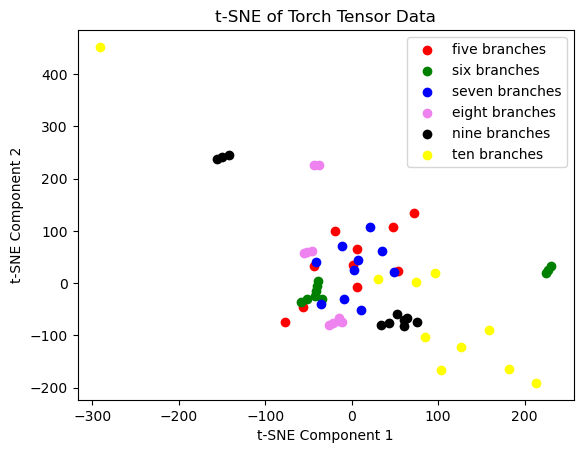

In [23]:
data = torch.cat([five_latent_out, six_latent_out, seven_latent_out, eight_latent_out, nine_latent_out, ten_latent_out], dim = 0)

colors = ['red', 'green', 'blue', 'violet', 'black', 'yellow']
branches = ["five", "six", "seven", "eight", "nine", "ten"]


tsne = TSNE(n_components=2, perplexity=num_samples - 9) 

for i, data_set_branch in enumerate(data):
    data_t_sne = data_set_branch.detach().numpy()
    data_tsne = tsne.fit_transform(data_t_sne)
    plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=colors[i], label=f'{branches[i]} branches')
    
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Torch Tensor Data')
plt.legend()
plt.show()
